In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import product
import matplotlib.pyplot as plt

%matplotlib inline

### Data Loading and Preprocessing

Training data has 346 rows (data samples) and 17 columns (16 input features, minus the first 'Outcome' column).

Next workings:
- Split the dataset into X_train and Y_train. 

- Scale data.

- Convert data into numpy array.

- LabelEncoder on y_train.

- Convert into pytorch tensors.

- Create DataLoader. (create a batch by extracting a slice from the dataset)

In [2]:
train_df = pd.read_csv("Fetus_trainingdata.csv")
test_df = pd.read_csv("Fetus_testingdata.csv")

X_train = train_df.drop('Outcome', axis=1)
y_train = train_df['Outcome']

X_test = test_df.drop('Outcome', axis=1)
y_test = test_df['Outcome']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = list(zip(X_train, y_train))
test_dataset = list(zip(X_test, y_test))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Preparing MLP

In [3]:
# Two layer neural network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(16, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 5)    # Changed 5 hidden units to 10 hidden units
        # self.softmax = nn.Softmax(dim=1)    # Applies across classes

    # Feedforward
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)    # raw logits
        # x = self.softmax(x)

        return logits

### Training the model

Binary Cross Entropy Loss

- y_pred: predicted probabilities, y_true: true labels (0 or 1)

- nn.CrossEntropyLoss expects raw logits → do not apply Softmax before it.

- During inference, if you want probabilities, then you can use torch.softmax(logits, dim=1).

- Model remains simpler and numerically stable.

In [4]:
def train(early_stopping=True):
    # Initialize model
    model = MyNet()

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Create an optimizer (Stochastic Gradient Descent - SGD)
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    # Initialize learning rate scheduler 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train the net
    epochs = 50
    # loss_per_iter = []
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    train_errors = []
    test_errors = []
    lrs = []

    patience = 10
    best_val_loss = float("inf") 
    patience_counter = 0
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        num_errors_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            logits = model(X_batch)    # forward pass
            loss = criterion(logits, y_batch)      
            loss.backward()
            optimizer.step()

            # Save loss to plot
            train_loss += loss.item()
            # loss_per_iter.append(loss.item())

            # Compute training accuracy
            preds = torch.argmax(logits, dim=1)
            num_errors_train += (preds != y_batch).sum().item()
            total_train += y_batch.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * (1 - num_errors_train / total_train)


        # Validation
        model.eval()
        test_loss = 0.0
        num_errors_test = 0
        total_test = 0

        with torch.no_grad():
            for X_test, y_test in test_loader:
                logits = model(X_test)
                loss = criterion(logits, y_test)
                test_loss += loss.item()

                probs = torch.softmax(logits, dim=1)    # convert logits -> probabilities
                preds = torch.argmax(probs, dim=1)
                total_test += y_test.size(0)      # Keeping track how many samples have been processed
                num_errors_test += (preds != y_test).sum().item()     # Count misclassified
        
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
        
        avg_test_loss = test_loss / len(test_loader)
        test_acc = 100 * (1 - num_errors_test / total_test)

        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        train_errors.append(num_errors_train)
        test_errors.append(num_errors_test)

        # Introducing early stopping
        if avg_test_loss < best_val_loss:
            best_val_loss = avg_test_loss
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if early_stopping and patience_counter >= patience:
                print(f"Early stopping at epoch {best_epoch + 1}")
                break

        print(f"Epoch [{epoch+1}/{epochs}] "
            f"Training Loss: {avg_train_loss:.4f} | "
            f"Training Accuracy: {train_acc:.2f}% | "
            f"Testing Loss: {avg_test_loss:.4f} | "
            f"Testing Accuracy: {test_acc:.2f}%")
        
    return train_losses, test_losses, best_epoch, train_accuracy, test_accuracy, lrs 


In [5]:
train_losses, test_losses, best_epoch, train_accuracy, test_accuracy, lrs = train()

Epoch [1/50] Training Loss: 1.6704 | Training Accuracy: 13.58% | Testing Loss: 1.3483 | Testing Accuracy: 41.38%
Epoch [2/50] Training Loss: 1.2260 | Training Accuracy: 52.02% | Testing Loss: 1.0486 | Testing Accuracy: 53.45%
Epoch [3/50] Training Loss: 1.0032 | Training Accuracy: 57.23% | Testing Loss: 0.9023 | Testing Accuracy: 65.52%
Epoch [4/50] Training Loss: 0.8780 | Training Accuracy: 61.85% | Testing Loss: 0.8232 | Testing Accuracy: 58.62%
Epoch [5/50] Training Loss: 0.8006 | Training Accuracy: 63.01% | Testing Loss: 0.7621 | Testing Accuracy: 68.97%
Epoch [6/50] Training Loss: 0.7473 | Training Accuracy: 67.05% | Testing Loss: 0.7138 | Testing Accuracy: 74.14%
Epoch [7/50] Training Loss: 0.7087 | Training Accuracy: 66.76% | Testing Loss: 0.6832 | Testing Accuracy: 75.86%
Epoch [8/50] Training Loss: 0.6840 | Training Accuracy: 65.32% | Testing Loss: 0.6554 | Testing Accuracy: 75.86%
Epoch [9/50] Training Loss: 0.6623 | Training Accuracy: 67.34% | Testing Loss: 0.6135 | Testing 

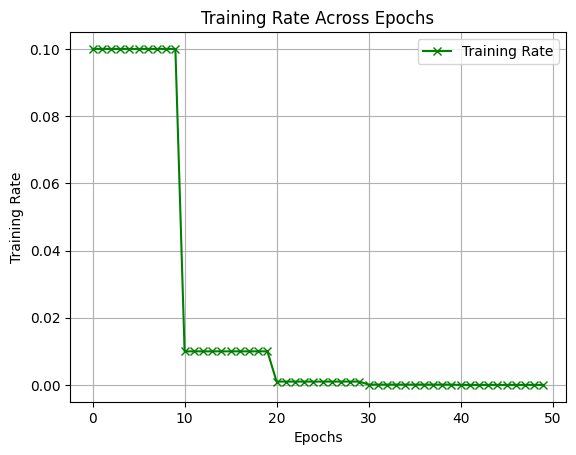

In [6]:
# Plotting learning rate across epochs
plt.plot(lrs, label='Training Rate', marker='x', color='green')
plt.xlabel('Epochs')
plt.ylabel("Training Rate")
plt.title('Training Rate Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

### Loss/Accuracy plots to check convergence and overfitting trends

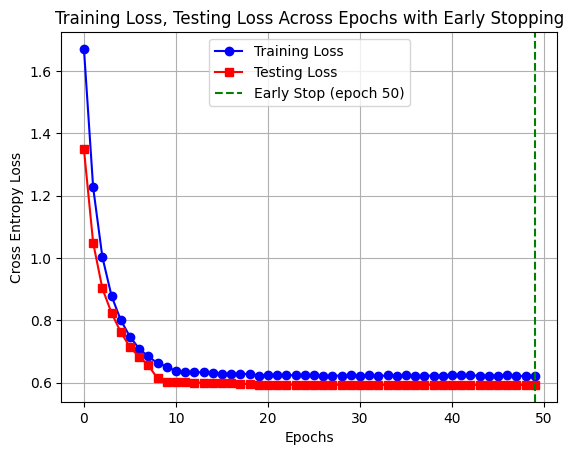

In [7]:
plt.plot(train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(test_losses, label='Testing Loss', marker='s', color='red')
plt.axvline(best_epoch, color='green', linestyle='--', label=f'Early Stop (epoch {best_epoch+1})')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss, Testing Loss Across Epochs with Early Stopping')
plt.grid(True)
plt.legend()
plt.show()

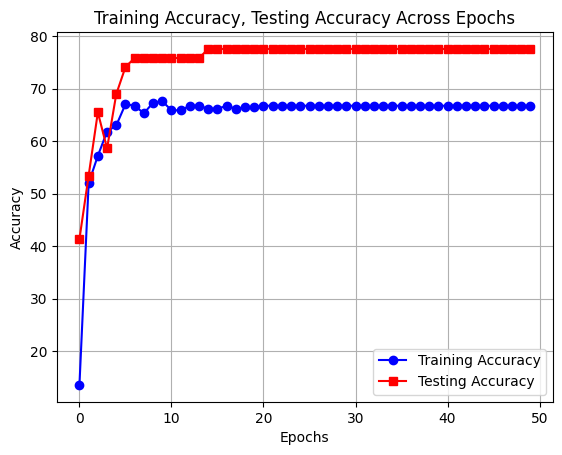

In [8]:
plt.plot(train_accuracy, label='Training Accuracy', marker='o', color='blue')
plt.plot(test_accuracy, label='Testing Accuracy', marker='s', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy, Testing Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

Findings:

- Based on the Loss plot, we can see that the learning curve is parallel and stable. This means that the model is a good fit.

Next workings:

- Analyze model fit and bias-variance tradeoff
- Introduces regularization. (To prevent overfitting)
- Get the best hyperparameters, parameters


**Hyperparameters Grid Search**

In [9]:
# Hyperparameters experiment
# Model definition for varying layers
class Net_VaryLayers(nn.Module):
    def __init__(self, activation_fn=nn.ReLU, num_layers=2, dropout_rate = 0.3):
        super(Net_VaryLayers, self).__init__()
        layers = []
        input_dim = 16
        hidden_dim = 10     # Increase hidden units (neurons)

        # Activation map (string name to class)
        if isinstance(activation_fn, str):
            activation_map = {
                'ReLU': nn.ReLU,
                'Tanh': nn.Tanh,
                'Sigmoid': nn.Sigmoid
            }
            activation_fn = activation_map[activation_fn]
        
        # Build hidden layer
        for i in range(num_layers - 1):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim

        # Final layer to 5 output classes    
        self. output_layer = nn.Linear(input_dim, 5)
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        logits = self.output_layer(x)
        return logits

In [30]:
param_grid = {
    "lr": [0.01, 0.05, 0.1],
    "num_layers": [2, 3],
    "activation": [nn.ReLU, nn.Tanh],
    "loss_fn": [nn.CrossEntropyLoss, nn.MSELoss],
    "weight_decay": [0.001, 0.01],
    "dropout_rate": [0.2, 0.3, 0.4]
}

In [21]:
# Finding best hyperparameters
def train_model(config, train_loader, test_loader, epochs=50, patience=10, early_stopping=True):
    
    if isinstance(config["loss_fn"], str):
            loss_fn_map = {
                'CrossEntropyLoss': nn.CrossEntropyLoss,
                'MSELoss': nn.MSELoss
            }
            config["loss_fn"] = loss_fn_map[config["loss_fn"]]
    
    model = Net_VaryLayers(
        num_layers=config["num_layers"],
        activation_fn=config["activation"],
    )

    optimizer = optim.SGD(model.parameters(),
                          lr=config["lr"],
                          weight_decay=config["weight_decay"])
    
    criterion = config["loss_fn"]()

    # Variables for plotting
    training_losses, testing_losses = [], []
    training_accuracy, testing_accuracy = [], []

    # Early stopping parameters
    best_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_training_loss, training_error, total_training = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)

            if isinstance(criterion, nn.MSELoss):
                y_onehot = nn.functional.one_hot(y_batch, num_classes=5).float()
                loss = criterion(torch.softmax(logits, dim=1), y_onehot)
            else:
                loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()

            total_training_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            training_error = (preds != y_batch).sum().item()
            total_training += y_batch.size(0)

        avg_training_loss = round(total_training_loss / len(train_loader), 4)
        training_accuracies = round(100 * (1 - training_error / total_training), 2)

        model.eval()
        total_testing_loss, testing_error, total_testing = 0, 0, 0

        with torch.no_grad():
            for X_test, y_test in test_loader:
                logits = model(X_test)

                if isinstance(criterion, nn.MSELoss):
                    y_onehot = nn.functional.one_hot(y_test, num_classes=5).float()
                    loss = criterion(torch.softmax(logits, dim=1), y_onehot)
                else:
                    loss = criterion(logits, y_test)

                total_testing_loss += loss.item()    
                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                testing_error = (preds != y_test).sum().item()
                total_testing += y_test.size(0)

        avg_testing_loss = round(total_testing_loss / len(test_loader), 4)
        testing_accuracies = round(100 * (1 - testing_error / total_testing), 2)

        training_losses.append(avg_training_loss)
        testing_losses.append(avg_testing_loss)
        training_accuracy.append(training_accuracies)
        testing_accuracy.append(testing_accuracies)

        print(f"Epoch [{epoch+1}/{epochs}] "
            f"Training Loss: {avg_training_loss:.4f} | Training Accuracy: {training_accuracies:.2f}% | "
            f"Testing Loss: {avg_testing_loss:.4f} | Testing Accuracy: {testing_accuracies:.2f}%")

        # Early stopping
        if avg_testing_loss < best_loss:
            best_loss = avg_testing_loss
            best_epoch = epoch 
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                model.load_state_dict(best_model_state)
                break

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {
        "training_losses": training_losses,
        "testing_losses": testing_losses,
        "training_accuracy": training_accuracy,
        "testing_accuracy": testing_accuracy,
        "final_training_accuracy": training_accuracy[-1],
        "final_testing_accuracy": testing_accuracy[-1],
        "num_params": num_params,
        "best_epoch": best_epoch,
        "model": model
    }

In [31]:
configs = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

In [32]:
results = []

for i, cfg in enumerate(configs):
    print(f"\nRunning configuration {i+1}/{len(configs)}: {cfg}")
    metrics = train_model(cfg, train_loader, test_loader, epochs=50, patience=10, early_stopping=True)
    metrics.update(cfg)
    results.append({
        "num_layers": cfg["num_layers"],
        "lr": cfg["lr"],
        "activation": cfg["activation"].__name__,
        "loss_fn": cfg["loss_fn"].__name__,
        "weight_decay": cfg["weight_decay"],
        "dropout_rate": cfg["dropout_rate"],
        "train_acc": metrics["final_training_accuracy"],
        "test_acc": metrics["final_testing_accuracy"],
        "params": metrics["num_params"],
        "best_epoch": metrics["best_epoch"],
        "model": metrics["model"]
    })


Running configuration 1/144: {'lr': 0.01, 'num_layers': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'loss_fn': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'weight_decay': 0.001, 'dropout_rate': 0.2}
Epoch [1/50] Training Loss: 1.4118 | Training Accuracy: 95.95% | Testing Loss: 1.4221 | Testing Accuracy: 75.86%
Epoch [2/50] Training Loss: 1.3703 | Training Accuracy: 95.95% | Testing Loss: 1.3826 | Testing Accuracy: 77.59%
Epoch [3/50] Training Loss: 1.3181 | Training Accuracy: 96.24% | Testing Loss: 1.3471 | Testing Accuracy: 77.59%
Epoch [4/50] Training Loss: 1.2847 | Training Accuracy: 96.24% | Testing Loss: 1.3147 | Testing Accuracy: 75.86%
Epoch [5/50] Training Loss: 1.2702 | Training Accuracy: 95.95% | Testing Loss: 1.2820 | Testing Accuracy: 77.59%
Epoch [6/50] Training Loss: 1.2362 | Training Accuracy: 96.53% | Testing Loss: 1.2523 | Testing Accuracy: 77.59%
Epoch [7/50] Training Loss: 1.2073 | Training Accuracy: 96.53% | Testing Loss: 1.2249 | Testing Acc

In [33]:
results_df = pd.DataFrame(results)
results_df.sort_values("test_acc", ascending=False).head(10)

,num_layers,lr,activation,loss_fn,weight_decay,dropout_rate,train_acc,test_acc,params,best_epoch,model
122,3,0.10,ReLU,CrossEntropyLoss,0.001,0.4,96.82,93.10,335,44,Net_VaryLayers(\n (output_layer): Linear(in_f...
41,3,0.01,Tanh,CrossEntropyLoss,0.010,0.4,96.82,93.10,335,49,Net_VaryLayers(\n (output_layer): Linear(in_f...
117,2,0.10,Tanh,MSELoss,0.010,0.2,97.11,91.38,225,49,Net_VaryLayers(\n (output_layer): Linear(in_f...
2,2,0.01,ReLU,CrossEntropyLoss,0.001,0.4,95.66,91.38,225,49,Net_VaryLayers(\n (output_layer): Linear(in_f...
115,2,0.10,Tanh,MSELoss,0.001,0.3,95.95,91.38,225,49,Net_VaryLayers(\n (output_layer): Linear(in_f...
119,2,0.10,Tanh,MSELoss,0.010,0.4,96.24,91.38,225,49,Net_VaryLayers(\n (output_layer): Linear(in_f...
74,3,0.05,ReLU,CrossEntropyLoss,0.001,0.4,98.27,91.38,335,44,Net_VaryLayers(\n (output_layer): Linear(in_f...
1,2,0.01,ReLU,CrossEntropyLoss,0.001,0.3,97.69,91.38,225,49,Net_VaryLayers(\n (output_layer): Linear(in_f...
26,3,0.01,ReLU,CrossEntropyLoss,0.001,0.4,96.82,89.66,335,49,Net_VaryLayers(\n (output_layer): Linear(in_f...
58,2,0.05,ReLU,MSELoss,0.010,0.3,95.95,89.66,225,49,Net_VaryLayers(\n (output_layer): Linear(in_f...


In [34]:
results_df["best_epoch"].value_counts()

best_epoch
49    108
47      5
48      4
44      4
42      3
43      3
39      2
27      2
38      2
29      2
28      2
25      2
30      2
41      1
40      1
31      1
Name: count, dtype: int64

In [35]:
best = results_df.sort_values("test_acc", ascending=False).iloc[0]
print("\nBest Hyperparameters")
best


Best Hyperparameters


num_layers                                                      3
lr                                                            0.1
activation                                                   ReLU
loss_fn                                          CrossEntropyLoss
weight_decay                                                0.001
dropout_rate                                                  0.4
train_acc                                                   96.82
test_acc                                                     93.1
params                                                        335
best_epoch                                                     44
model           Net_VaryLayers(\n  (output_layer): Linear(in_f...
Name: 122, dtype: object

### Optimized Model

In [36]:
best_cfg = best.to_dict()
best_epoch = best['best_epoch']
optimized_model = train_model(best_cfg, train_loader, test_loader, epochs=best_epoch, patience=10, early_stopping=True)

Epoch [1/44] Training Loss: 1.3934 | Training Accuracy: 96.82% | Testing Loss: 1.2107 | Testing Accuracy: 79.31%
Epoch [2/44] Training Loss: 1.1208 | Training Accuracy: 95.66% | Testing Loss: 1.0045 | Testing Accuracy: 79.31%
Epoch [3/44] Training Loss: 0.9675 | Training Accuracy: 96.24% | Testing Loss: 0.8801 | Testing Accuracy: 81.03%
Epoch [4/44] Training Loss: 0.8836 | Training Accuracy: 95.66% | Testing Loss: 0.8073 | Testing Accuracy: 86.21%
Epoch [5/44] Training Loss: 0.8298 | Training Accuracy: 96.24% | Testing Loss: 0.7672 | Testing Accuracy: 87.93%
Epoch [6/44] Training Loss: 0.7963 | Training Accuracy: 95.95% | Testing Loss: 0.7402 | Testing Accuracy: 86.21%
Epoch [7/44] Training Loss: 0.7789 | Training Accuracy: 97.98% | Testing Loss: 0.7212 | Testing Accuracy: 87.93%
Epoch [8/44] Training Loss: 0.7670 | Training Accuracy: 96.53% | Testing Loss: 0.7095 | Testing Accuracy: 86.21%
Epoch [9/44] Training Loss: 0.7484 | Training Accuracy: 96.82% | Testing Loss: 0.6987 | Testing 

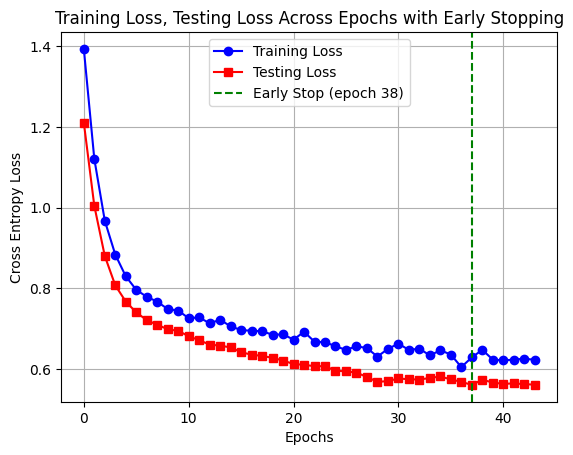

In [37]:
training_losses = optimized_model["training_losses"]
testing_losses = optimized_model["testing_losses"]
training_accuracy = optimized_model["training_accuracy"]
testing_accuracy = optimized_model["testing_accuracy"]
best_epoch = optimized_model["best_epoch"]

plt.plot(training_losses, label='Training Loss', marker='o', color='blue')
plt.plot(testing_losses, label='Testing Loss', marker='s', color='red')
plt.axvline(best_epoch, color='green', linestyle='--', label=f'Early Stop (epoch {best_epoch+1})')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss, Testing Loss Across Epochs with Early Stopping')
plt.grid(True)
plt.legend()
plt.show()

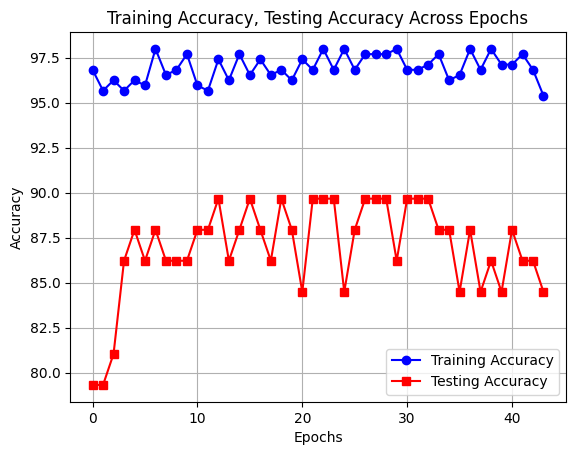

In [38]:
plt.plot(training_accuracy, label='Training Accuracy', marker='o', color='blue')
plt.plot(testing_accuracy, label='Testing Accuracy', marker='s', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy, Testing Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [39]:
best_cfg_df = pd.DataFrame.from_dict(best_cfg, orient='index').T
best_cfg_df = best_cfg_df.drop('model', axis=1)
best_cfg_df.loc[0, 'loss_fn'] = 'CrossEntropyLoss'
best_cfg_df

,num_layers,lr,activation,loss_fn,weight_decay,dropout_rate,train_acc,test_acc,params,best_epoch
0,3,0.1,ReLU,CrossEntropyLoss,0.001,0.4,96.82,93.1,335,44
